In [64]:
from sklearn.preprocessing import OneHotEncoder
from utils_public import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm, trange
import seaborn as sns
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.metrics import r2_score
def plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, advisor): 
    #Calculates 
    plt.figure(figsize=(6,3))
    plt.scatter(ratings_train, preds_train, label='Train Set Preds', s=3, c = "#BBBBBB") #train set in gray
    plt.scatter(ratings_test, preds_test, label='Test Set Preds', s=5, c = "#DC267F") #test set in magenta
    plt.plot([0,1], [0,1], label="Target", linewidth=3, c="k") #target line in black

    #Set axis labels and title
    plt.xlabel("Actual Rating")
    plt.ylabel("Predicted Rating")
    plt.title(f"Advisor {advisor} Predictions")

    #Turn off top and right spines
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.legend() #Display legend
    plt.show() #Show plot

    #Calculate R2 score for train and test sets
    print(f"Advisor {advisor} Train Set R2 score: {r2_score(ratings_train, preds_train)}") 
    print(f"Advisor {advisor} Test Set R2 score: {r2_score(ratings_test, preds_test)}")


In [65]:
# Load data and run the model
grids = load_grids()
ratings = np.load("datasets/scores.npy")
ratings_df = pd.DataFrame(ratings, columns=["Wellness", "Tax", "Transportation", "Business"])

In [66]:
import numpy as np
import random

num_iterations = 2  # how many new grids to create per original grid
num_cell_to_replace = 2  # how many cells to modify in each new grid

new_grids = []
new_ratings = []

for _ in range(num_iterations):
    for grid in grids:
        # Generate modified versions of the grid
        new_grid = grid.copy()
        for _ in range(num_cell_to_replace):
            # Select random cell coordinates
            x, y = random.randint(0, 6), random.randint(0, 6)
            current_val = grid[x, y]
            # Choose a different random value for replacement
            new_val = random.choice([v for v in range(5) if v != current_val])
            new_grid[x, y] = new_val
        new_grids.append(new_grid)
        new_ratings.append([np.nan] * 4)

# Convert lists to numpy arrays
new_grids = np.array(new_grids)
new_ratings = np.array(new_ratings)

# Combine with existing data
all_grids = np.vstack((grids, new_grids))
all_ratings = np.vstack((ratings, new_ratings))

# Remove duplicates
unique_grids, unique_indices = np.unique(all_grids, axis=0, return_index=True)
unique_ratings = all_ratings[unique_indices]

print(f"Number of unique grids: {unique_grids.shape[0]}")

# set to activate
# grid = unique_grids.copy()

Number of unique grids: 1499932



Training model for Advisor 0
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0585 - mae: 0.1972 - val_loss: 0.0405 - val_mae: 0.1619
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0585 - mae: 0.1972 - val_loss: 0.0405 - val_mae: 0.1619
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0370 - mae: 0.1515 - val_loss: 0.0424 - val_mae: 0.1644
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0370 - mae: 0.1515 - val_loss: 0.0424 - val_mae: 0.1644
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0299 - mae: 0.1347 - val_loss: 0.0481 - val_mae: 0.1773
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0299 - mae: 0.1347 - val_loss: 0.0481 - val_mae: 0.1773
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0236 - mae: 0.1180 - val_loss: 0.0303 - val_mae: 0.1368
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0236 - mae: 0.1180 - val_loss: 0.0303 - val_mae: 0.1368
Epoch 5/50
125/125 ━━━━━━━

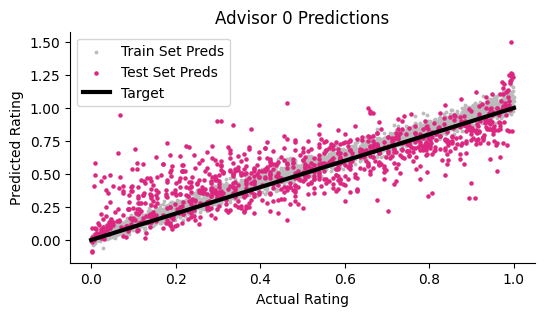

Advisor 0 Train Set R2 score: 0.9701451503349501
Advisor 0 Test Set R2 score: 0.6491943414617632
46873/46873 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step
46873/46873 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step

Training model for Advisor 1
Epoch 1/50

Training model for Advisor 1
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0602 - mae: 0.1995 - val_loss: 0.0259 - val_mae: 0.1287
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0602 - mae: 0.1995 - val_loss: 0.0259 - val_mae: 0.1287
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0227 - mae: 0.1211 - val_loss: 0.0174 - val_mae: 0.1056
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0227 - mae: 0.1211 - val_loss: 0.0174 - val_mae: 0.1056
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0161 - mae: 0.1008 - val_loss: 0.0145 - val_mae: 0.0959
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0161 - mae: 0.1008 - val_loss: 0.0145 - val_mae: 0.0959
Epoch 4/50
125/125 ━━━━━━━━━━━━━

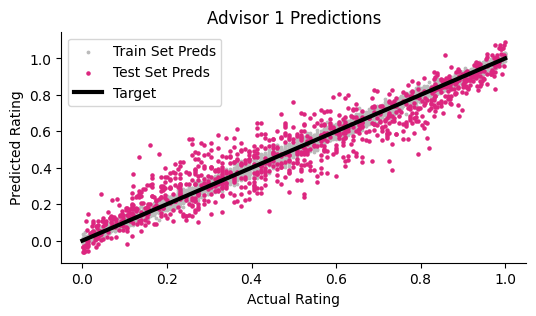

Advisor 1 Train Set R2 score: 0.995060723584964
Advisor 1 Test Set R2 score: 0.8909071859824753
46873/46873 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step
46873/46873 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step

Training model for Advisor 2
Epoch 1/50

Training model for Advisor 2
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0769 - mae: 0.2320 - val_loss: 0.0595 - val_mae: 0.2050
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0769 - mae: 0.2320 - val_loss: 0.0595 - val_mae: 0.2050
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0554 - mae: 0.1953 - val_loss: 0.0513 - val_mae: 0.1835
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0554 - mae: 0.1953 - val_loss: 0.0513 - val_mae: 0.1835
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0441 - mae: 0.1700 - val_loss: 0.0456 - val_mae: 0.1733
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0441 - mae: 0.1700 - val_loss: 0.0456 - val_mae: 0.1733
Epoch 4/50
125/125 ━━━━━━━━━━━━━━

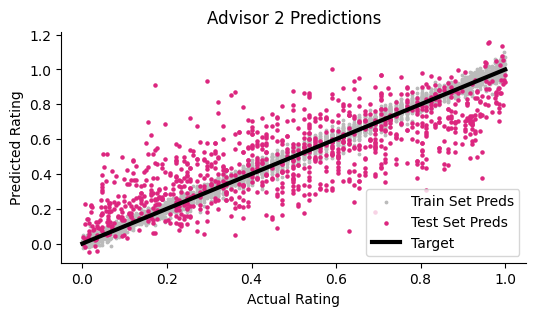

Advisor 2 Train Set R2 score: 0.9905037514313029
Advisor 2 Test Set R2 score: 0.6080965387319417
46873/46873 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step
46873/46873 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step

Training model for Advisor 3
Epoch 1/50

Training model for Advisor 3
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0603 - mae: 0.1979 - val_loss: 0.0462 - val_mae: 0.1760
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0603 - mae: 0.1979 - val_loss: 0.0462 - val_mae: 0.1760
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0389 - mae: 0.1574 - val_loss: 0.0407 - val_mae: 0.1546
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0389 - mae: 0.1574 - val_loss: 0.0407 - val_mae: 0.1546
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0338 - mae: 0.1459 - val_loss: 0.0360 - val_mae: 0.1424
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0338 - mae: 0.1459 - val_loss: 0.0360 - val_mae: 0.1424
Epoch 4/50
125/125 ━━━━━━━━━━━━━

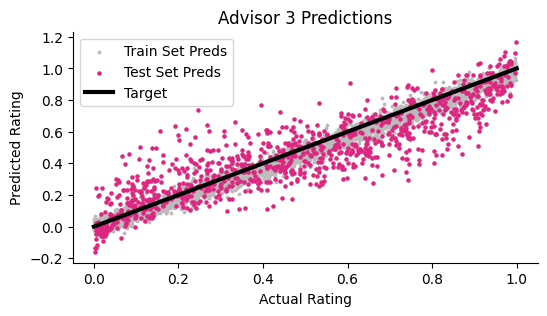

Advisor 3 Train Set R2 score: 0.9793943748810664
Advisor 3 Test Set R2 score: 0.7789602713124494
46873/46873 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step
46873/46873 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step


In [67]:


all_predictions = [] #empty list to hold predictions
histories = []  # Store training histories for each advisor
for advisor in range(4): #loop over four advisors
    print(f"\nTraining model for Advisor {advisor}")
    grids_subset, ratings_subset = select_rated_subset(grids, ratings[:,advisor]) #gets subset of the dataset 
    X_train, X_validation, Y_train, Y_validation = train_test_split(grids_subset, ratings_subset, test_size=.2, random_state=42)

    height, width = 7, 7
    num_pixel_classes = 5  # pixels take values 0 to 4
    # # One-hot encoding of categorical pixel values
    X_train_encoded = tf.one_hot(X_train, depth=num_pixel_classes)  # Shape: (4000, 7, 7, 5)
    X_validation_encoded = tf.one_hot(X_validation, depth=num_pixel_classes)  # Shape: (4000, 7, 7, 5)

    # Build CNN model for regression
    model = models.Sequential([
        layers.Input(shape=(height, width, num_pixel_classes)),
        layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(2, 2), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='linear')  # Single output for regression
    ])

    # Compile model with mean squared error loss for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Train the model and capture history
    history = model.fit(
        X_train_encoded, 
        Y_train, 
        batch_size=32, 
        epochs=50, 
        validation_data=(X_validation_encoded, Y_validation),
        verbose=1
    )
    histories.append(history)  # Store the training history

    #predict
    preds_train = model.predict(X_train_encoded) #predict on the train set
    preds_test = model.predict(X_validation_encoded) #predict on the test set

    plot_and_r2(preds_train, preds_test, Y_train, Y_validation, advisor)
    
    grids_encoded = tf.one_hot(unique_grids, depth=num_pixel_classes)  # Shape: (X, 7, 7, 5)
    # Merge predictions with actual ratings
    predictions = model.predict(grids_encoded) #predict on the train set

    mask = np.where(~np.isnan(ratings[:,advisor])) #get the indices of the rated grids
    predictions[mask, 0] = ratings[:, advisor][mask]  # assign to 2D predictions
    all_predictions.append(predictions) #append predictions
    all_predictions = [np.squeeze(a) for a in all_predictions]

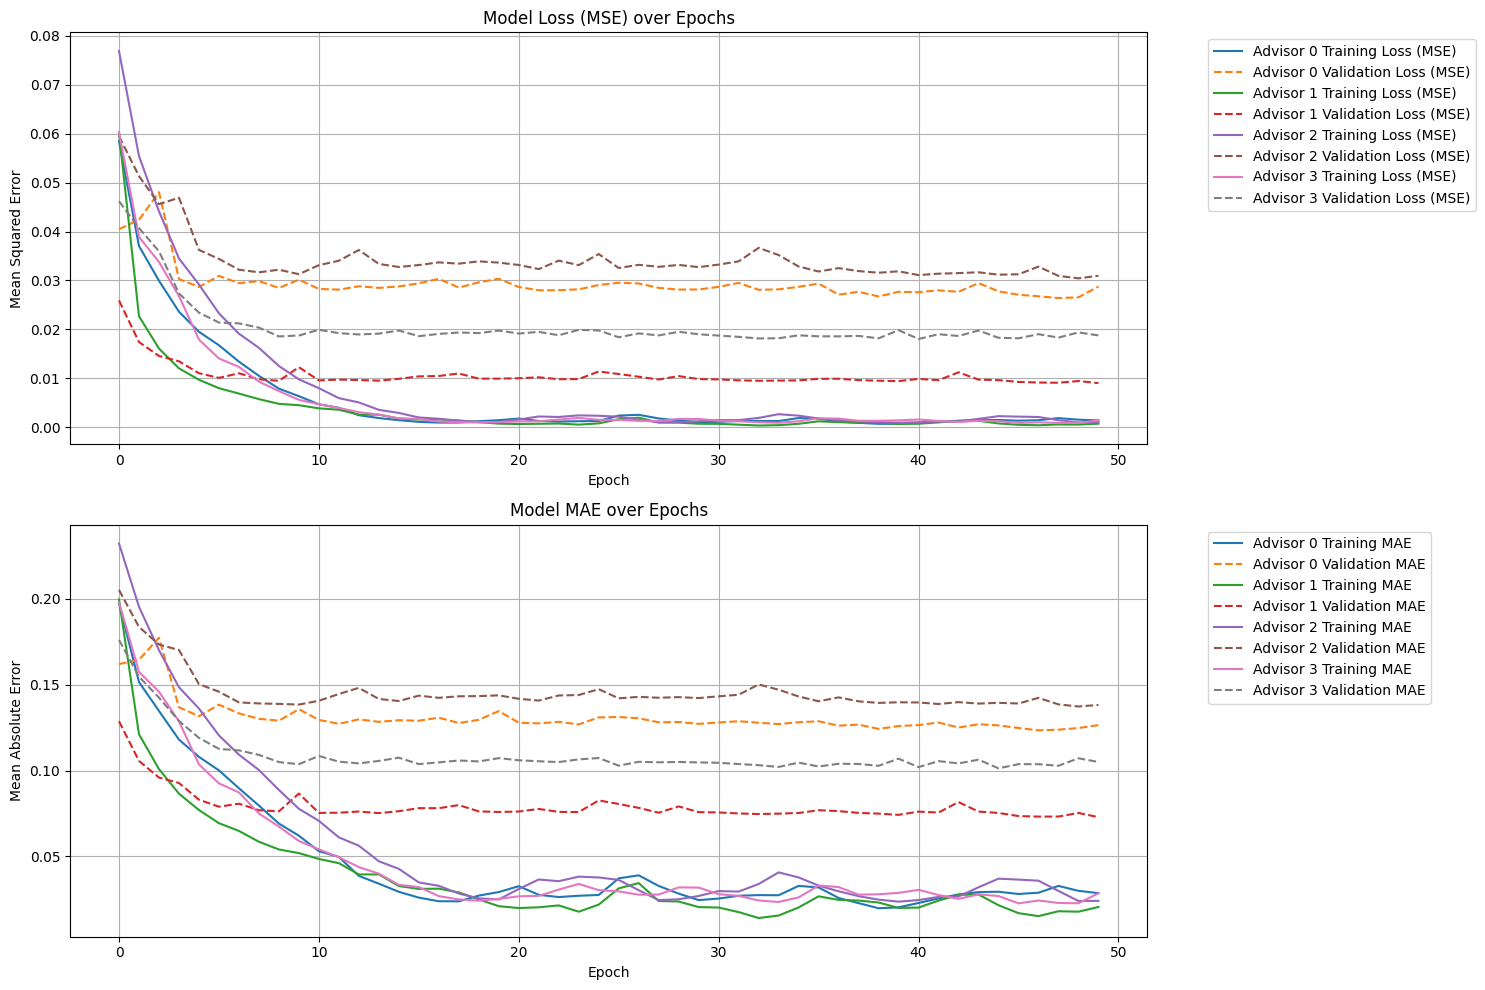


Advisor 0 final metrics:
Training Loss (MSE): 0.0014
Validation Loss (MSE): 0.0288
Training MAE: 0.0286
Validation MAE: 0.1264

Advisor 1 final metrics:
Training Loss (MSE): 0.0007
Validation Loss (MSE): 0.0090
Training MAE: 0.0206
Validation MAE: 0.0729

Advisor 2 final metrics:
Training Loss (MSE): 0.0009
Validation Loss (MSE): 0.0310
Training MAE: 0.0242
Validation MAE: 0.1382

Advisor 3 final metrics:
Training Loss (MSE): 0.0014
Validation Loss (MSE): 0.0187
Training MAE: 0.0286
Validation MAE: 0.1050


In [68]:
# Plot convergence curves for all advisors
plt.figure(figsize=(15, 10))

# Plot MSE Loss
plt.subplot(2, 1, 1)
for idx, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Advisor {idx} Training Loss (MSE)')
    plt.plot(history.history['val_loss'], label=f'Advisor {idx} Validation Loss (MSE)', linestyle='--')
plt.title('Model Loss (MSE) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Plot MAE
plt.subplot(2, 1, 2)
for idx, history in enumerate(histories):
    plt.plot(history.history['mae'], label=f'Advisor {idx} Training MAE')
    plt.plot(history.history['val_mae'], label=f'Advisor {idx} Validation MAE', linestyle='--')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics for each advisor
for idx, history in enumerate(histories):
    print(f"\nAdvisor {idx} final metrics:")
    print(f"Training Loss (MSE): {history.history['loss'][-1]:.4f}")
    print(f"Validation Loss (MSE): {history.history['val_loss'][-1]:.4f}")
    print(f"Training MAE: {history.history['mae'][-1]:.4f}")
    print(f"Validation MAE: {history.history['val_mae'][-1]:.4f}")

In [118]:
# mask = np.where(~np.isnan(ratings[:,advisor])) #get the indices of the rated grids
# # predictions = predictions.reshape(-1, predictions.shape[0])
# predictions[mask, 0] = ratings[:, advisor][mask]  # assign to 2D predictions
# # predictions[mask] = ratings[:,advisor][mask] #replace the predictions with the actual ratings where available
# all_predictions.append(predictions) #append predictions


final_prediction_array = np.stack(all_predictions).T #stack the predictions
min_predictions = np.min(final_prediction_array, axis=1) #minimum advisor score (as predicted)
# print(f"Number of valid grids (as predicted): {np.sum((min_predictions > 0.9) & (min_predictions < 1.1))}") #number of valid grids (as predicted)
print(f"Number of valid grids (as predicted): {np.sum(min_predictions > 0.8)}") #number of valid grids (as predicted)
top_100_indices = np.argpartition(min_predictions, -100)[-100:] #indices of top 100 designs (as sorted by minimum advisor score)
top_100_grids = unique_grids[top_100_indices] #get the top 100 grids
print(f"top_100_grids: {top_100_grids[:1]}")

#take the second best 100 from top 200
top_500_indices = np.argpartition(min_predictions, -200)[-200:]  # indices of top 200 designs
top_500_indices = top_500_indices[np.argsort(-min_predictions[top_500_indices])] #sort
final_prediction_array[top_500_indices[:100]]
top_100_grids = unique_grids[top_500_indices[400:500]] #get the top 100 grids
top_500_grids = unique_grids[top_500_indices] #get the top 500 grids

min_predictions_top5 = np.min(top_100_grids, axis=1) #minimum advisor score (as predicted)
print(top_100_grids.shape)
print(f"top_100_grids: {top_100_grids[:1]}")
final_prediction_array[top_100_indices]



Number of valid grids (as predicted): 1048
top_100_grids: [[[4. 4. 4. 4. 1. 4. 4.]
  [4. 4. 0. 0. 2. 4. 4.]
  [3. 0. 3. 3. 0. 4. 4.]
  [3. 3. 0. 0. 3. 0. 4.]
  [3. 0. 2. 2. 0. 2. 4.]
  [4. 4. 0. 4. 4. 1. 4.]
  [4. 4. 3. 0. 2. 4. 4.]]]
(0, 7, 7)
top_100_grids: []


array([[1.0532848 , 0.9283046 , 0.99456394, 1.0786225 ],
       [0.92895687, 0.9555785 , 1.0718969 , 1.1254818 ],
       [0.99899244, 0.9292353 , 1.2660617 , 0.9357623 ],
       [1.0727185 , 1.023137  , 1.1155257 , 0.9293824 ],
       [0.9294497 , 1.063333  , 0.9465623 , 0.9592635 ],
       [1.1008314 , 0.9296302 , 1.1379288 , 1.0013626 ],
       [0.9305162 , 0.9651863 , 1.0078541 , 1.052456  ],
       [0.9306328 , 0.97154725, 1.0416764 , 1.137694  ],
       [0.9310413 , 0.98428136, 1.1544876 , 1.1519877 ],
       [0.93117225, 0.9754826 , 1.1614435 , 0.963314  ],
       [1.0392725 , 0.9314584 , 1.1032906 , 0.9681628 ],
       [1.063577  , 0.9322075 , 0.9822973 , 1.0038096 ],
       [1.0476378 , 0.99408466, 0.93250203, 1.0332751 ],
       [0.98874694, 0.99672353, 0.9734216 , 0.93258953],
       [0.94211906, 1.0327682 , 1.0022182 , 0.9330627 ],
       [1.1010274 , 1.0179163 , 0.9606669 , 0.9330666 ],
       [0.961933  , 0.9395824 , 0.93314505, 1.0081216 ],
       [1.055507  , 0.9468564 ,

In [119]:
def compute_grid_distance(grid1, grid2):
    """Compute the distance between two grids based on element-wise differences"""
    return np.sum(grid1 != grid2)  # Count different elements

def select_diverse_grids(grids, n_select=100):
    """
    Select n_select most diverse grids from the input grids using a greedy approach.
    Args:
        grids: numpy array of shape (N, 7, 7) containing grid designs
        n_select: number of grids to select
    Returns:
        numpy array of shape (n_select, 7, 7) containing selected diverse grids
    """
    n_grids = len(grids)
    
    # Start with the first grid
    selected_indices = [0]
    remaining_indices = list(range(1, n_grids))
    
    # Greedy selection: at each step, select the grid that is most different from already selected ones
    for _ in range(n_select - 1):
        max_min_distance = -1
        best_idx = -1
        
        # For each remaining grid
        for idx in remaining_indices:
            # Compute minimum distance to any selected grid
            min_distance = float('inf')
            for selected_idx in selected_indices:
                distance = compute_grid_distance(grids[idx], grids[selected_idx])
                min_distance = min(min_distance, distance)
            
            # Update best candidate if this grid has a larger minimum distance
            if min_distance > max_min_distance:
                max_min_distance = min_distance
                best_idx = idx
        
        # Add the best grid to selected and remove from remaining
        selected_indices.append(best_idx)
        remaining_indices.remove(best_idx)
    
    return grids[selected_indices]

# Select 100 most diverse grids from top 500
diverse_grids = select_diverse_grids(top_500_grids, n_select=100)
print(f"Selected {len(diverse_grids)} diverse grids")

# Calculate average pairwise distance to verify diversity
total_distance = 0
n_pairs = 0
for i in range(len(diverse_grids)):
    for j in range(i + 1, len(diverse_grids)):
        total_distance += compute_grid_distance(diverse_grids[i], diverse_grids[j])
        n_pairs += 1

avg_distance = total_distance / n_pairs
print(f"Average pairwise distance between selected grids: {avg_distance:.2f} different elements")

# Show shape of the selected grids
print(f"Shape of selected grids: {diverse_grids.shape}")

# Update top_100_grids with the diverse selection
top_100_grids = diverse_grids

Selected 100 diverse grids
Average pairwise distance between selected grids: 24.78 different elements
Shape of selected grids: (100, 7, 7)


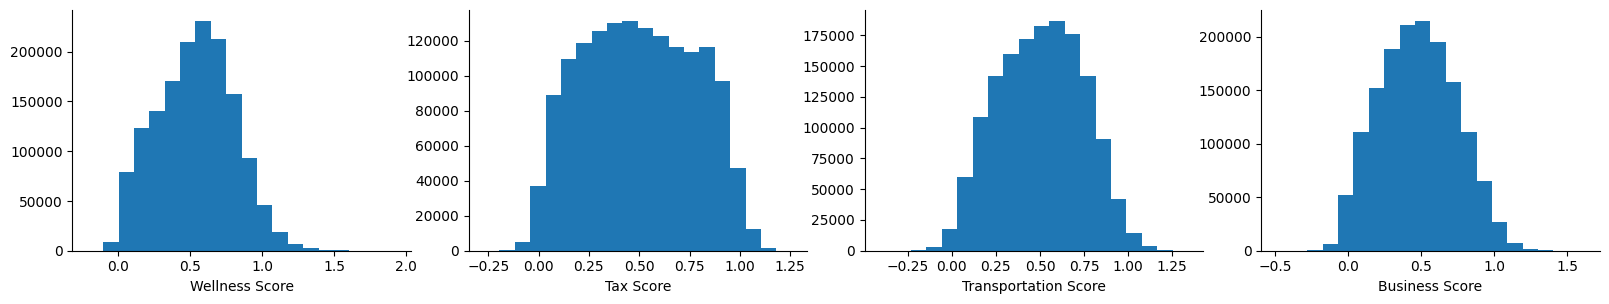

In [99]:
plot_ratings_histogram(final_prediction_array, withmin=False) #plot histograms of top 100 designs

In [120]:
score = diversity_score(top_100_grids)
print(f"Hypothetical diversity score if all top 100 grids are valid: {score:.4f} ")

Hypothetical diversity score if all top 100 grids are valid: 0.5007 


In [121]:
final_submission = top_100_grids.astype(int)
assert final_submission.shape == (100, 7, 7)
assert final_submission.dtype == int
assert np.all(np.greater_equal(final_submission, 0) & np.less_equal(final_submission, 4))
id = np.random.randint(1e8, 1e9-1)
np.save(f"results/{id}.npy", final_submission)
print(id)

511314208


In [ ]:
top 100
Submission Successful!
Name: Patryk&Angela
Nickname: Patryk&Angela
# Invalid grids: 5
Mean advisor rating (all advisors, all grids): 0.9596925926849548
Score: 0.40858367346938773
Submission ID: 61199621-5c5c-4f38-9122-f87615f8cc8e

top second 100
Submission Successful!
Name: Patryk&Angela
Nickname: Patryk&Angela
# Invalid grids: 11
Mean advisor rating (all advisors, all grids): 0.9523805852710479
Score: 0.3774
Submission ID: 2254a970-e1ca-4bd5-9656-f13a36f728c5


top third 100
Submission Successful!
Name: Patryk&Angela
Nickname: Patryk&Angela
# Invalid grids: 9
Mean advisor rating (all advisors, all grids): 0.9462318970556141
Score: 0.4081102040816327
Submission ID: be449510-b190-4fae-9387-16f19a83f4f7

4
Submission Successful!
Name: Patryk&Angela
Nickname: Patryk&Angela
# Invalid grids: 18
Mean advisor rating (all advisors, all grids): 0.9378541694451326
Score: 0.33855510204081635
Submission ID: 76ad3233-0c75-45db-abb0-a27624250e0c

5
Submission Successful!
Name: Patryk&Angela
Nickname: Patryk&Angela
# Invalid grids: 16
Mean advisor rating (all advisors, all grids): 0.9419590764106018
Score: 0.34891836734693876
Submission ID: 5d532188-06a8-4755-a2f1-adfec25858e2

after the selection of diverse grids
Submission Successful!
Name: Patryk&Angela
Nickname: Patryk&Angela
# Invalid grids: 18
Mean advisor rating (all advisors, all grids): 0.9290512422197501
Score: 0.3576530612244898
Submission ID: 7cd8bcb4-52ac-4e53-b9d6-4523c52e22ba

out of top 1000
Submission Successful!
Name: Patryk&Angela
Nickname: Patryk&Angela
# Invalid grids: 26
Mean advisor rating (all advisors, all grids): 0.9074144134730059
Score: 0.29511020408163263
Submission ID: 715da021-fee3-479c-8d89-965bbf283da7

out of 200
Submission Successful!
Name: Patryk&Angela
Nickname: Patryk&Angela
# Invalid grids: 9
Mean advisor rating (all advisors, all grids): 0.9516056723356537
Score: 0.4150122448979592
Submission ID: 979efc73-bc95-45ac-a7e6-8f88f74cbcda

SyntaxError: invalid decimal literal (1336598940.py, line 7)

In [ ]:
# def train_model(model, X_train, Y_train, X_validation, Y_validation, num_epochs=10, batch_size=32, learning_rate=0.001, device='cuda'):
#     """
#     Function to train a given model (CNN or DNN) using training and validation data.

#     Args:
#     - model: The model to train (e.g., CNN or DNN).
#     - X_train: Training data (features).
#     - Y_train: Training data (labels).
#     - X_validation: Validation data (features).
#     - Y_validation: Validation data (labels).
#     - num_epochs: Number of training epochs (default: 10).
#     - batch_size: Batch size for training (default: 32).
#     - learning_rate: Learning rate for the optimizer (default: 0.001).
#     - device: Device to run the model on ('cuda' or 'cpu').

#     Returns:
#     - train_losses: List of training losses for each epoch.
#     - val_losses: List of validation losses for each epoch.
#     """

#     # Move model to the specified device (GPU or CPU)
#     model = model.to(device)

#     # Define loss function (Mean Squared Error for regression tasks)
#     criterion = nn.MSELoss()

#     # Define optimizer (Adam optimizer with specified learning rate)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     # Create DataLoader for batching the training data
#     train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#     # Create DataLoader for batching the validation data
#     validation_dataset = TensorDataset(torch.tensor(X_validation, dtype=torch.float32), torch.tensor(Y_validation, dtype=torch.float32))
#     validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

#     # Lists to store train and validation losses
#     train_losses = []
#     val_losses = []

#     # Training loop
#     for epoch in range(num_epochs):
#         model.train()  # Set model to training mode
#         running_loss = 0.0

#         # Using tqdm for the training loop progress bar
#         train_loader_tqdm = tqdm(train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}]', leave=False)

#         # Iterate over batches of training data
#         for inputs, labels in train_loader_tqdm:
#             inputs = inputs.to(device)  # Move inputs to device (GPU/CPU)
#             labels = labels.to(device)  # Move labels to device (GPU/CPU)

#             # Zero the gradients before the next update
#             optimizer.zero_grad()

#             # Forward pass: compute model outputs
#             outputs = model(inputs)

#             # Compute the loss
#             loss = criterion(outputs, labels)

#             # Backward pass: compute gradients
#             loss.backward()

#             # Perform a single optimization step (update model parameters)
#             optimizer.step()

#             # Accumulate loss over the batch
#             running_loss += loss.item() * inputs.size(0)

#             # Update tqdm progress bar with current loss
#             train_loader_tqdm.set_postfix({'Train Loss': running_loss / len(train_loader.dataset)})

#         # Calculate average training loss for the epoch
#         epoch_loss = running_loss / len(train_loader.dataset)
#         train_losses.append(epoch_loss)

#         # Validation loop (no gradient computation)
#         model.eval()  # Set model to evaluation mode
#         val_loss = 0.0
#         with torch.no_grad():
#             for inputs, labels in validation_loader:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # Forward pass: compute model outputs
#                 outputs = model(inputs)

#                 # Compute validation loss
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)

#         # Calculate average validation loss for the epoch
#         val_loss /= len(validation_loader.dataset)
#         val_losses.append(val_loss)

#         # Print the train and validation loss at the end of each epoch
#         print(f'Epoch [{epoch + 1}/{num_epochs}] - Train MSE: {epoch_loss:.4f} - Validation MSE: {val_loss:.4f}')

#     print("Training complete.")

#     # Return the recorded training and validation losses
#     return train_losses, val_losses


In [ ]:
# class CNN(nn.Module):
#     def __init__(self):  # Define all the layers here
#         super(CNN, self).__init__()
#         # All pooling will use 2x2 window and stride 2
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         # First Conv layer: 1 input channel (grayscale), 4 output channels, kernel size 3x3, stride 1, padding 1
#         self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)

#         # Second Conv layer: 4 input channels, 8 output channels
#         self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)

#         # Third Conv layer: 8 input channels, 16 output channels
#         self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)

#         # Fourth Conv layer: 16 input channels, 32 output channels
#         self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

#         # Operation to flatten the images into a vector
#         self.flatten = nn.Flatten()

#         # Fully connected layers
#         self.fc1 = nn.Linear(32 * 3 * 3, 16)  # Adjusted to match the output size after conv3
#         self.fc2 = nn.Linear(16, 1)  # 5 output classes

#     def forward(self, x):  # Call all the layers in this function
#         # Reshape the input to ensure it has the correct channel dimension: [batch x 1 x 50 x 50]
#         if len(x.shape) == 3:  # Input is [batch x 50 x 50]
#             x = x.unsqueeze(1)  # Add channel dimension -> [batch x 1 x 50 x 50]

#         # Convolve, then pass through ReLU, then pooling
#         x = F.relu(self.conv1(x))  # [batch x 4 x 50 x 50]
#         x = self.pool(x)  # [batch x 4 x 25 x 25]

#         x = F.relu(self.conv2(x))  # [batch x 8 x 25 x 25]
#         x = self.pool(x)  # [batch x 8 x 12 x 12]

#         x = F.relu(self.conv3(x))  # [batch x 16 x 12 x 12]
#         x = self.pool(x)  # [batch x 16 x 6 x 6]

#         x = F.relu(self.conv4(x))  # [batch x 32 x 6 x 6]
#         x = self.pool(x)  # [batch x 32 x 3 x 3]

#         x = self.flatten(x)  # Flatten for the fully connected layer [batch x 288]

#         # Pass through fully connected layers with ReLU
#         x = F.relu(self.fc1(x))  # [batch x 16]

#         # Final fully connected layer with no activation (since we are doing regression)
#         x = self.fc2(x)  # Output layer with 5 outputs [batch x 5]
#         return x

# # Create a CNN model instance
# model_cnn = CNN()
# model_cnn.to(device)

# # Print the model's architecture
# summary(model_cnn, input_size=(1, 50, 50))  # Adjusted input size for grayscale images with 1 channel